#Import libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image
import time
import functools

The function `load_image` reads an image and contrain the size of the image to maximum of $512$ pixels along the longest dimension.

In [5]:
def load_img(path_to_img):

  max_dim = 512

  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  
  return img

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path_to_img = '/content/drive/MyDrive/Cher Eng Lim - content_Tuebingen_Neckarfront.jpg.zip (Unzipped Files)/Cher Eng Lim - content_Tuebingen_Neckarfront.jpg'

In [8]:
image = load_img(path_to_img)

In [10]:
#height=number of rows;  width=number of columns
_, image_height, image_width,_ = image.shape 

In [11]:
print(image_height, image_width)

384 512


In [12]:
import cv2

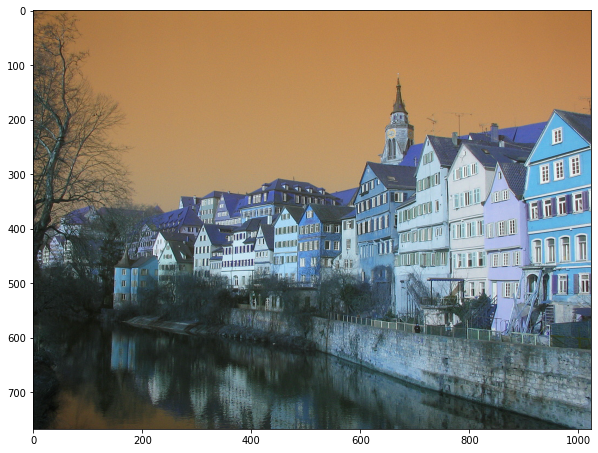

In [13]:
#check out the image content
image_show = cv2.imread(path_to_img)
plt.imshow(image_show)
plt.show()

#Part 1: Load and explore VGG19

##Load VGG19 model without the top part.

In [14]:
vgg = tf.keras.applications.VGG19(
    weights = "imagenet",
    input_shape = (image_height, image_width, 3),
    include_top = False)
vgg.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


We can display

- number of layers
-names of layers

of VGG19.

In [17]:
print("Number of layers = ", len(vgg.layers))
print("Names of layers:")
for layer in vgg.layers:
  print(layer.name)

Number of layers =  22
Names of layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [18]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 128, 128)      0     

##Extract coefficients of filters of any convolution layer.

In [19]:
name = 'block1_conv1' # name of the convolution layer

# get filters' coefficients
a = vgg.get_layer(name).get_weights()

print("Type of a: ", type(a))
print("Length of a = ", len(a))

Type of a:  <class 'list'>
Length of a =  2


The result tells us that `a` is a list and it has two items. Let's explore those items.

In [20]:
print("Type of the first item: ", type(a[0]))
print("Shape of the first item: ", a[0].shape)

Type of the first item:  <class 'numpy.ndarray'>
Shape of the first item:  (3, 3, 3, 64)


You should have the size of (3, 3, 3, 64).

<font color="red"> Are you able to explain why we have the result? </font> 

**Answer**: 

Output of layer: m x m q x n
  - m x m: size of kernel. In VGG19, each layer has kernel_size = (3,3)
  - n: number of feature maps of the current layer (conv1_1 = 64)
  - q: number of feature maps of previous layer 
    - conv1_1, it is the 3 input channels
    - conv1_2, it will be the number of feature maps of conv1_1 (=64)

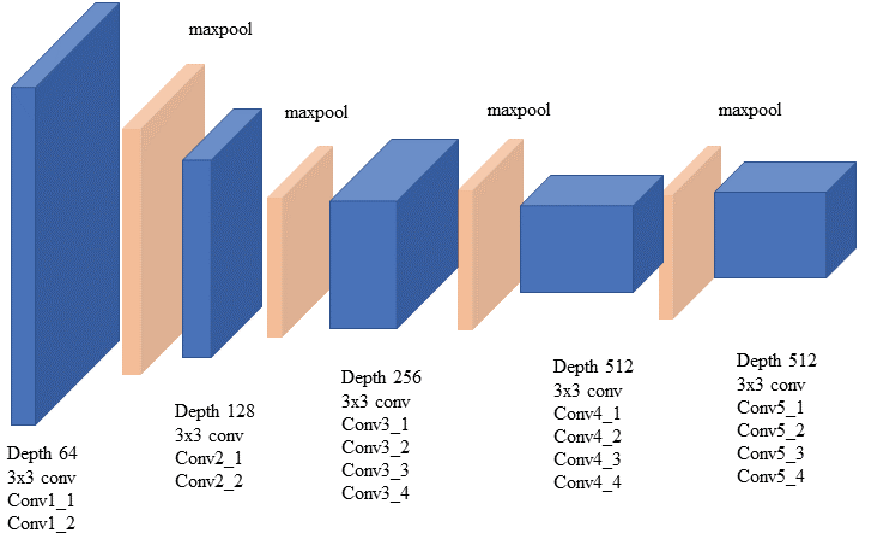

In [37]:
b = vgg.get_layer('block2_conv2').get_weights()
b[0].shape

(3, 3, 128, 128)

We can print out one filter of **block1_conv1**

In [38]:
a[0][:, :, :, 0]

array([[[ 0.34119523,  0.46418372,  0.39416704],
        [ 0.33999205,  0.41810837,  0.37740308],
        [-0.04484424, -0.04806903, -0.04594866]],

       [[ 0.23215917,  0.30511212,  0.2671299 ],
        [ 0.08978214,  0.10385381,  0.09986369],
        [-0.30331427, -0.37314063, -0.34100872]],

       [[-0.07260918, -0.07646758, -0.07573577],
        [-0.246675  , -0.3107071 , -0.2803425 ],
        [-0.33683276, -0.46453714, -0.41602272]]], dtype=float32)

How's about the second item of `a`?

In [39]:
print("Type of the second item: ", type(a[1]))
print("Shape of the second item: ", a[1].shape)

Type of the second item:  <class 'numpy.ndarray'>
Shape of the second item:  (64,)


<font color="red"> Are you able to explain why we have the shape (64,)? </font> 

**Answer**: 

64 bias because it has 64 feature maps

#Part 2: How to get the output of a convolution layer of VGG19

As presented in the lecture:

- CONTENT IMAGE $\longrightarrow$ VGG19 $\longrightarrow$ ouput of **block5_conv2** is used to calcuate $F^{1}$ matrix. $F^{1}$ is considered as "content target".

- STYLE IMAGE $\longrightarrow$ VGG19 $\longrightarrow$ ouputs of **block1_conv1**, **block2_conv1**, **block3_conv1**, **block4_conv1**, and **block5_conv1** are used to calcuate $5$ matrices: $G^{1}$, $G^{2}$, $G^{3}$, $G^{4}$ and $G^{5}$. Those matrices are considered as "style target".

##How to extract the output of **block5_conv2**?



Declare and initiate a list named `content_layers`. We write the code in such a way that we can extend it.

In [40]:
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

Build your own model.
 

In [41]:
def get_model():

  # Load VGG9 model without the top part
  vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

  # We freeze the whole VGG19
  vgg.trainable = False
  
  # Let's have an emply list
  # Name: content_ouputs 
  content_outputs = []

  # Have a for-loop here to scan through all elements of content_layers
  # For each element, append 'vgg.get_layer(....).output' to 
  # 'content_outputs'
  for content_layers in vgg.layers():
    content_outputs.append(content_outputs, content_layers)

  # Build your model by using
  # tf.keras.Model(...., ....)
  # First input: [vgg.input]
  # Second input: content_outputs

  model = tf.keras.Model([vgg.input], content_outputs)

  return model

In [61]:
def get_model_1():

  # Load VGG9 model without the top part
  vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

  # We freeze the whole VGG19
  vgg.trainable = False
  
  # Let's have an emply list
  # Name: content_ouputs 
  content_outputs = []
  list_of_ouputs = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2']

  for name in list_of_ouputs:
    content_outputs.append(vgg.get_layer(name).output)

  # Build your model by using
  # tf.keras.Model(...., ....)
  # First input: [vgg.input]
  # Second input: content_outputs

  model = tf.keras.Model([vgg.input], content_outputs)

  return model

In [75]:
def get_content(model, input):

  # Use: tf.keras.applications.vgg19.preprocess_input(input)
  # to transform your input into a suitable format for your model
  
  preprocessed_input = tf.keras.applications.vgg19.preprocess_input(input)
  
  # Pass it through the model
  outputs = model(preprocessed_input)
  
  # outputs is assigned to content_outputs
  content_outputs = outputs
  len(content_outputs)

  # It is convinient to have a dictionary to store the result
  # key:value
  # key: name of each element in content_layers
  # value: corresponding element in  content_outputs
  content_layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2']
  content_dict = {content_name:value 
                  for content_name, value 
                  in zip(content_layers, content_outputs)}
  
  # Let's return a dictionary
  # Key: 'content'
  # Value: the obtained dictionary, content_dict

  #return {'content': content_dict}
  return content_dict

#Part 3: Put them in action

We will pass the content image through the model and explore the obtained result.

Path to the content image.

In [63]:
content_path = '/content/drive/MyDrive/Cher Eng Lim - content_Tuebingen_Neckarfront.jpg.zip (Unzipped Files)/Cher Eng Lim - content_Tuebingen_Neckarfront.jpg'

Load the content image

In [64]:
content_image = load_img(content_path)

Call `get_model()` and assigned the model to `my_model`.

In [65]:
my_model_1 = get_model_1()

Call `get_content()` to have `content_targets`.

In [76]:
content_targets = get_content(my_model_1, content_image)

In [77]:
content_image.shape

TensorShape([1, 384, 512, 3])

Let's explore `content_targets`.

In [79]:
print("Type of content_targets:", type(content_targets))
print("Keys of content_targets", content_targets.keys())

# Have a list of keys
keys = list(content_targets.keys())

# You must get block5_conv2 after this
keys[4]

Type of content_targets: <class 'dict'>
Keys of content_targets dict_keys(['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2'])


'block5_conv2'

Get the value of `content_targets`.

In [80]:
a = content_targets[keys[0]]

print("Type:", type(a))

Type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [81]:
b = a.numpy()
print("Shape: ", b.shape)

Shape:  (1, 384, 512, 64)


<font color="red"> Are you able to explain why we have the <font color="black"> 512</font> ? </font> 

Answer: Width=((W-F+2P )/S)+1; Ht=((H-F+2P )/S)+1 (padding=same)

key[0] refers to block1_conv2, output shape = 384x512x64 
